#### Load the pretrain model and generate GPS Trajectories

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
from types import SimpleNamespace
from utils.Traj_UNet import *
from utils.config import args
from utils.utils import *
from torch.utils.data import DataLoader

In [13]:
temp = {}
for k, v in args.items():
    temp[k] = SimpleNamespace(**v)

config = SimpleNamespace(**temp)

unet = Guide_UNet(config).cuda()
# load the model
unet.load_state_dict(torch.load('./DiffTraj/Porto_steps=500_len=200_0.05_bs=512/models/08-01-18-07-21/unet_200.pt'))

<All keys matched successfully>

In [35]:
n_steps = config.diffusion.num_diffusion_timesteps
beta = torch.linspace(config.diffusion.beta_start,
                          config.diffusion.beta_end, n_steps).cuda()
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)
lr = 2e-4  # Explore this - might want it lower when training on the full dataset

eta=0.0
timesteps=100
skip = n_steps // timesteps
seq = range(0, n_steps, skip)

# load head information for guide trajectory generation
batchsize = 500
head = np.load('porto_heads.npy',
                   allow_pickle=True)
head = torch.from_numpy(head).float()
dataloader = DataLoader(head, batch_size=batchsize, shuffle=True, num_workers=4)

In [ ]:
# the mean and std of head information, using for rescaling
# departure_time, trip_distance,  trip_time, trip_length, avg_dis, avg_speed
hmean=[0, 10283.41600429,   961.66920921,   292.30299616,    36.02766493, 10.98568072]
hstd=[1, 8782.599246414231, 379.41939897358264, 107.24874828393955, 28.749924691281066, 8.774629812281198]
mean = np.array([104.07596303,   30.68085491])
std = np.array([2.15106194e-02, 1.89193207e-02])
# the original mean and std of trajectory length, using for rescaling the trajectory length
len_mean = 292.30299616  # Chengdu
len_std = 107.2487482839  # Chengdu

In [15]:
# Porto
# the mean and std of head information, using for rescaling
# departure_time, trip_distance,  trip_time, trip_length, avg_dis, avg_speed
hmean=[0, 8029.154791, 1745.890854, 117.392724, 74.209811, 4.997468]
hstd=[1, 3974.428351, 1072.389402, 71.492627, 33.856621, 2.283029]
mean = np.array([-8.622851773110616, 41.15821200010704])
std = np.array([0.025654276995489916, 0.010499445425612607])
# the original mean and std of trajectory length, using for rescaling the trajectory length
len_mean = 117.392724 # porto
len_std = 71.492627 # porto

In [16]:
tqdm.pandas()

In [37]:
Gen_traj = []
Gen_head = []
for i in tqdm(range(1)):
    head = next(iter(dataloader))
    lengths = head[:, 3]
    lengths = lengths * len_std + len_mean
    lengths = lengths.int()
    tes = head[:,:6].numpy()
    Gen_head.extend((tes*hstd+hmean))
    head = head.cuda()
    # Start with random noise
    x = torch.randn(batchsize, 2, config.data.traj_length).cuda()
    ims = []
    n = x.size(0)
    seq_next = [-1] + list(seq[:-1])
    for i, j in zip(reversed(seq), reversed(seq_next)):
        t = (torch.ones(n) * i).to(x.device)
        next_t = (torch.ones(n) * j).to(x.device)
        with torch.no_grad():
            pred_noise = unet(x, t, head)
            # print(pred_noise.shape)
            x = p_xt(x, pred_noise, t, next_t, beta, eta)
            if i % 10 == 0:
                ims.append(x.cpu().squeeze(0))
    trajs = ims[-1].cpu().numpy()
    trajs = trajs[:,:2,:]
    # resample the trajectory length
    for j in range(batchsize):
        new_traj = resample_trajectory(trajs[j].T, lengths[j])
        new_traj = new_traj * std + mean
        Gen_traj.append(new_traj)
    break


  0%|          | 0/1 [00:08<?, ?it/s]


Converting Gen_traj to LineStrings: 100%|██████████| 500/500 [00:00<00:00, 248979.22it/s]


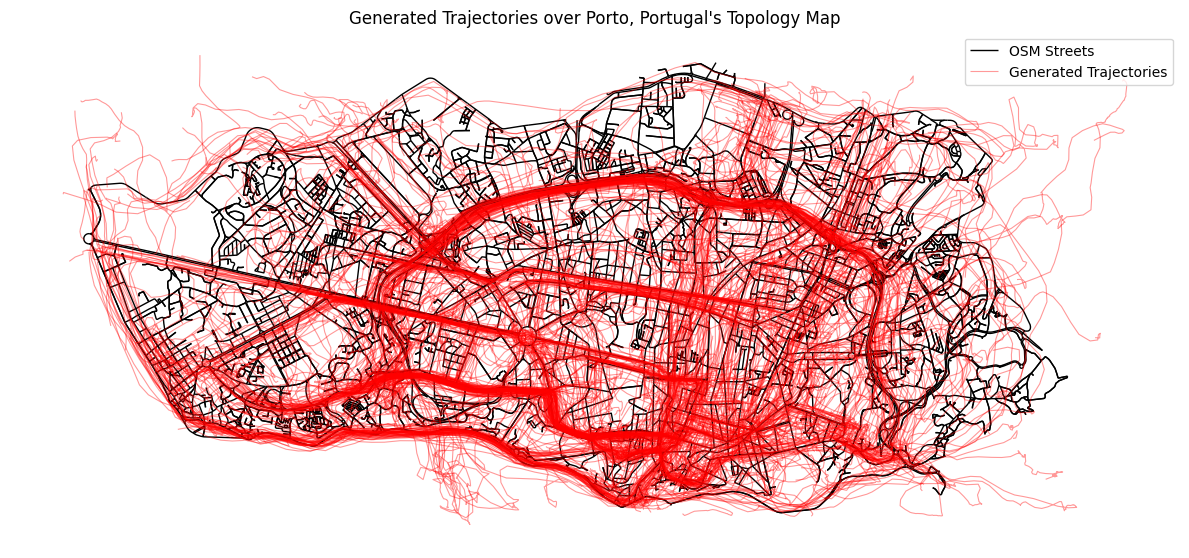

In [38]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString
from tqdm import tqdm

def plot_gen_traj_on_topology(Gen_traj, city_name="Porto, Portugal"):
    """
    Plot generated trajectories on top of the street network of the specified city.

    Parameters:
        Gen_traj (list of np.ndarray): Each trajectory is an array of shape (N, 2)
        city_name (str): Name of the city to load from OSM
    """
    # Convert Gen_traj into GeoDataFrame
    line_geoms = []
    for traj in tqdm(Gen_traj, desc="Converting Gen_traj to LineStrings"):
        traj = np.asarray(traj)
        if traj.shape[0] < 2:
            continue
        if traj.shape[1] == 2:
            line = LineString(traj)
        elif traj.shape[0] == 2:
            line = LineString(traj.T)
        else:
            continue
        line_geoms.append(line)

    gdf_traj = gpd.GeoDataFrame(geometry=line_geoms, crs="EPSG:4326").to_crs(epsg=3857)

    # Get Porto road network
    G = ox.graph_from_place(city_name, network_type='drive')
    nodes, edges = ox.graph_to_gdfs(G)
    edges = edges.to_crs(epsg=3857)

    # Plot
    fig, ax = plt.subplots(figsize=(12, 12))
    edges.plot(ax=ax, linewidth=1, color='black', alpha=1, label="OSM Streets")
    gdf_traj.plot(ax=ax, linewidth=0.8, color='red', alpha=0.4, label="Generated Trajectories")
    plt.title(f"Generated Trajectories over {city_name}'s Topology Map")
    ax.axis('off')
    plt.tight_layout()
    plt.legend()
    plt.show()
plot_gen_traj_on_topology(Gen_traj)

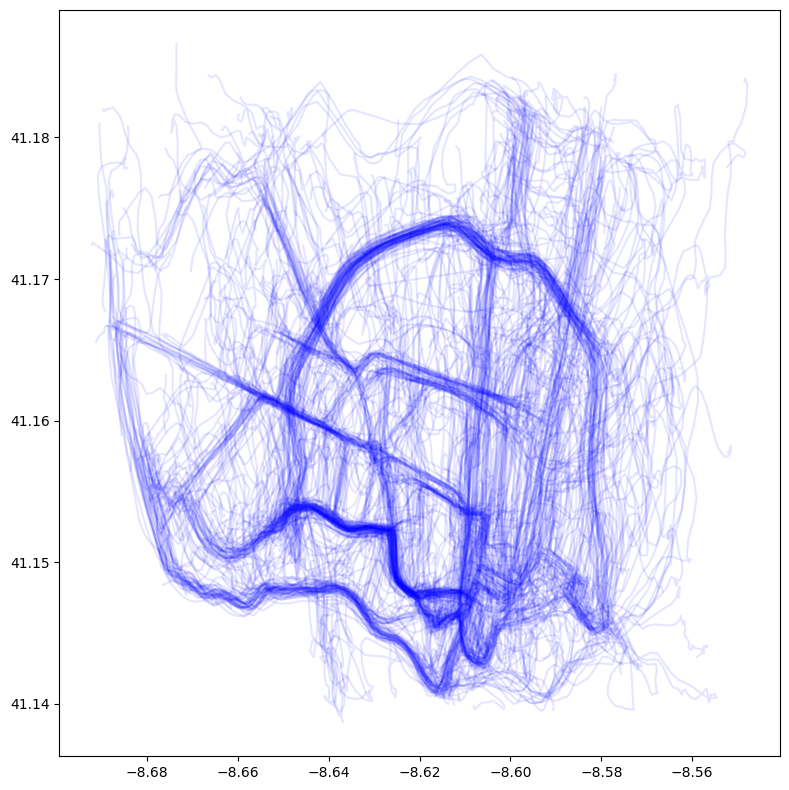

In [39]:
plt.figure(figsize=(8,8))
for i in range(len(Gen_traj)):
    traj=Gen_traj[i]
    # plt.plot(traj[:,0],traj[:,1],color='blue',alpha=0.1)
    plt.plot(traj[:,0],traj[:,1],color='blue',alpha=0.1)
plt.tight_layout()
plt.savefig('porto_traj.png')
plt.show()